In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import awswrangler as wr
import pandas as pd

In [2]:
# Load the preprocessed-dataset
final_s3_path = "s3://chung-yeh-youbike-poc-data/processed/youbike_data_for_modeling.parquet"
df_model = wr.s3.read_parquet(path=final_s3_path)
print("Data loaded successfully!")

Data loaded successfully!


### Step 1: Define Features (X) and Target (y)

In [5]:
# Select the features that the model will use to make predictions, and exclude non-numeric columns that are not useful as features.
features = [
    'total',
    'available_rent_bikes',
    'latitude',
    'longitude',
    'available_return_bikes',
    'hour',
    'day_of_week',
    'is_weekend'
]

target = 'status_in_15_mins'

X = df_model[features]
y = df_model[target]

# Convert categorical target to numerical codes for the model
y = y.astype('category')
label_map = dict(enumerate(y.cat.categories))
y = y.cat.codes

### Step 2: Time-Based Data Split

In [6]:
# For time-series data, train on the past and test(last 20%) on the most recent data.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (12659196, 8)
Testing set shape: (3164800, 8)


### Step 3: Train the LightGBM Model

In [7]:
print("\nTraining LightGBM model...")
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
print("Model training complete.")


Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 12659196, number of used features: 8
[LightGBM] [Info] Start training from score -2.999445
[LightGBM] [Info] Start training from score -3.914308
[LightGBM] [Info] Start training from score -0.272121
[LightGBM] [Info] Start training from score -1.781003
Model training complete.


### Step 4: Evaluate the Model


Classification Report:
              precision    recall  f1-score   support

       EMPTY       0.72      0.67      0.69    233132
        FULL       0.64      0.26      0.37     69568
     HEALTHY       0.94      0.96      0.95   2261451
         LOW       0.77      0.79      0.78    600649

    accuracy                           0.89   3164800
   macro avg       0.77      0.67      0.70   3164800
weighted avg       0.88      0.89      0.88   3164800


Confusion Matrix:


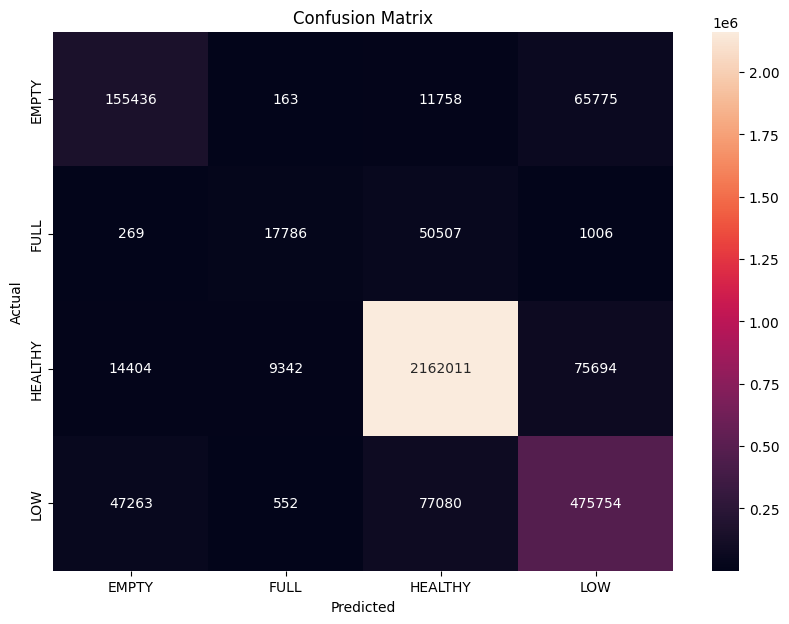

In [8]:
y_pred = lgb_clf.predict(X_test)

# Convert numerical predictions back to original labels for readability
y_test_labels = [label_map[i] for i in y_test]
y_pred_labels = [label_map[i] for i in y_pred]

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=list(label_map.values()))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()